In [1]:
import os
import librosa
import numpy as np

# --- Config ---
SR = 16000
N_MELS = 64
DURATION = 3  # seconds
SAMPLES = SR * DURATION
CLASS_MAP = {"real": 0, "fake": 1}

# --- 1. Feature Extraction ---
def extract_log_mel(path):
    # Load audio file with specified sample rate
    y, _ = librosa.load(path, sr=SR, mono=True)
    
    # Ensure consistent length
    y = librosa.util.fix_length(y, size=SAMPLES)
    
    # Calculate mel spectrogram - fixed by passing y as a named parameter
    mel_spec = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS)
    
    # Convert to log scale (dB)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel

# --- 2. Load Dataset into Arrays ---
def load_dataset(split_dir):
    X, y = [], []
    for label in CLASS_MAP:
        class_dir = os.path.join(split_dir, label)
        if not os.path.exists(class_dir):
            continue
        files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]
        for fname in files:
            fpath = os.path.join(class_dir, fname)
            try:
                log_mel = extract_log_mel(fpath)
                X.append(log_mel)
                y.append(CLASS_MAP[label])
            except:
                continue

    X = np.array(X)
    y = np.array(y)

    X = X[..., np.newaxis]
    return X, y

# def load_dataset(split_dir):
#     X, y = [], []
#     for label in CLASS_MAP:
#         class_dir = os.path.join(split_dir, label)
#         if not os.path.exists(class_dir):
#             print(f"Warning: Directory {class_dir} does not exist.")
#             continue
            
#         files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]
#         if not files:
#             print(f"Warning: No WAV files found in {class_dir}")
#             continue
            
#         print(f"Processing {len(files)} {label} files...")
        
#         for fname in files:
#             fpath = os.path.join(class_dir, fname)
#             try:
#                 log_mel = extract_log_mel(fpath)
#                 X.append(log_mel)
#                 y.append(CLASS_MAP[label])
#             except Exception as e:
#                 print(f"Error loading {fpath}: {e}")
    
#     if not X:
#         raise ValueError("No valid audio files were processed!")
        
#     X = np.array(X)
#     y = np.array(y)
    
#     # Normalize features
#     X = (X - np.mean(X)) / np.std(X)
    
#     # Shuffle data with fixed seed for reproducibility
#     idx = np.random.RandomState(seed=42).permutation(len(X))
#     X, y = X[idx], y[idx]
    
#     return X[..., np.newaxis], y  # Add channel dimension for CNN compatibility

# # --- 3. Usage Example ---
# if __name__ == "__main__":
#     base_path = "data_preprocessed"
    
#     if not os.path.exists(base_path):
#         print(f"Error: Base directory {base_path} does not exist.")
#         print("Please ensure your data is organized as follows:")
#         print("data_preprocessed/")
#         print("├── training/")
#         print("│   ├── real/")
#         print("│   └── fake/")
#         print("├── validation/")
#         print("│   ├── real/")
#         print("│   └── fake/")
#         print("└── testing/")
#         print("    ├── real/")
#         print("    └── fake/")
#     else:
#         for split in ["training", "validation", "testing"]:
#             split_path = os.path.join(base_path, split)
#             if not os.path.exists(split_path):
#                 print(f"Warning: {split_path} directory not found, skipping.")
#                 continue
                
#             print(f"\nLoading {split} data...")
#             try:
#                 X, y = load_dataset(split_path)
#                 print(f"{split.capitalize()} set: {X.shape} features, {y.shape} labels")
#                 print(f"Class distribution: {np.bincount(y)} (0=real, 1=fake)")
#             except Exception as e:
#                 print(f"Error processing {split} data: {e}")

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- 3. Build DNN Model ---
def build_dnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [3]:
if __name__ == "__main__":
    base_path = "Data_Split"

    # # Load datasets
    # X_train, y_train = load_dataset(os.path.join(base_path, "training"))
    # X_val, y_val = load_dataset(os.path.join(base_path, "validation"))
    # X_test, y_test = load_dataset(os.path.join(base_path, "testing"))

    np.random.seed(42)
    tf.random.set_seed(42)

    print("Loading training data...")
    X_train, y_train = load_dataset(os.path.join(base_path, "training"))
    print(f"Training set: {X_train.shape}, {y_train.shape}, Class distribution: {np.bincount(y_train)}")

    print("\nLoading validation data...")
    X_val, y_val = load_dataset(os.path.join(base_path, "validation"))
    print(f"Validation set: {X_val.shape}, {y_val.shape}, Class distribution: {np.bincount(y_val)}")

    print("\nLoading testing data...")
    X_test, y_test = load_dataset(os.path.join(base_path, "testing"))
    print(f"Testing set: {X_test.shape}, {y_test.shape}, Class distribution: {np.bincount(y_test)}")

# Compute normalization stats from training set only
    mean = np.mean(X_train)
    std = np.std(X_train)

# Normalize all splits using train stats
    X_train = (X_train - mean) / std
    X_val   = (X_val - mean) / std
    X_test  = (X_test - mean) / std
    print(f"\nTrain: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

    # Build and train model
    model = build_dnn(X_train.shape[1:])

    history=model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=10,
              batch_size=32,
              shuffle=True)

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_acc:.4f}")


Loading training data...
Training set: (48509, 64, 94, 1), (48509,), Class distribution: [24223 24286]

Loading validation data...
Validation set: (10394, 64, 94, 1), (10394,), Class distribution: [5190 5204]

Loading testing data...
Testing set: (10397, 64, 94, 1), (10397,), Class distribution: [5192 5205]

Train: (48509, 64, 94, 1), Validation: (10394, 64, 94, 1), Test: (10397, 64, 94, 1)
Epoch 1/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8910 - loss: 0.2891 - val_accuracy: 0.9745 - val_loss: 0.0676
Epoch 2/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9644 - loss: 0.0960 - val_accuracy: 0.9864 - val_loss: 0.0418
Epoch 3/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9768 - loss: 0.0642 - val_accuracy: 0.9886 - val_loss: 0.0300
Epoch 4/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9809 - loss: 0.0561 - val_accuracy: 0.9934 - val_loss: 0.0202
Epoch 5/10
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9841 - loss: 0.046

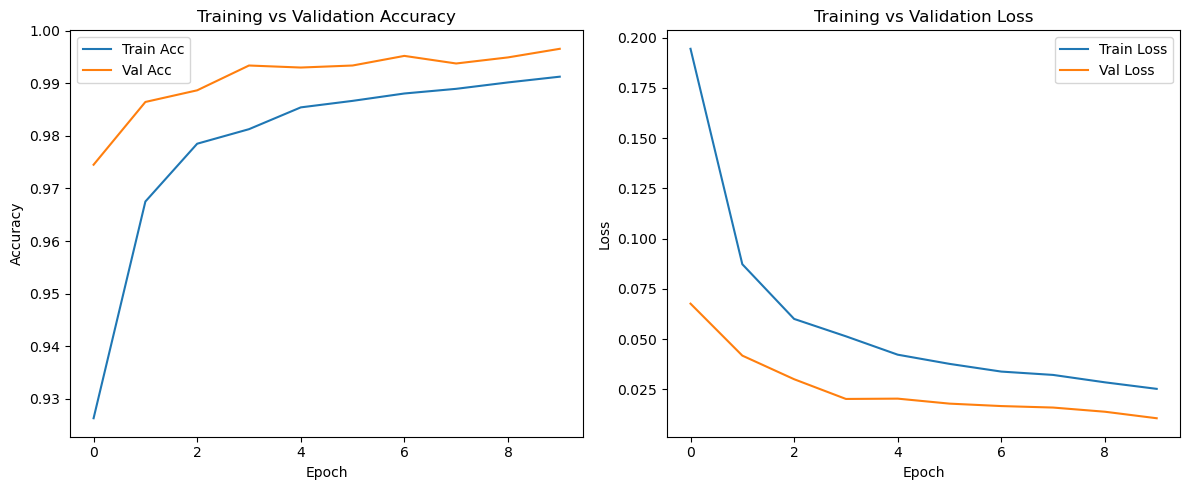

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Plot accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


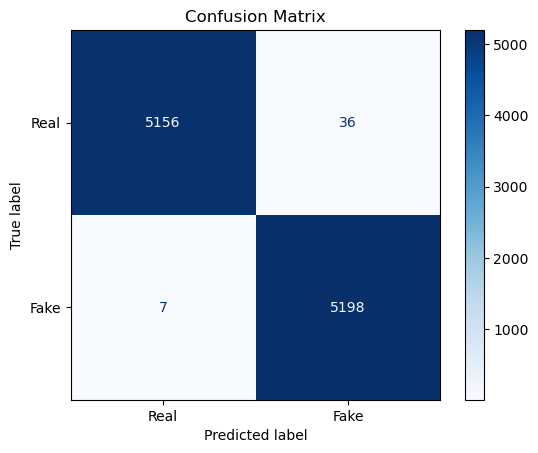

In [5]:
# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


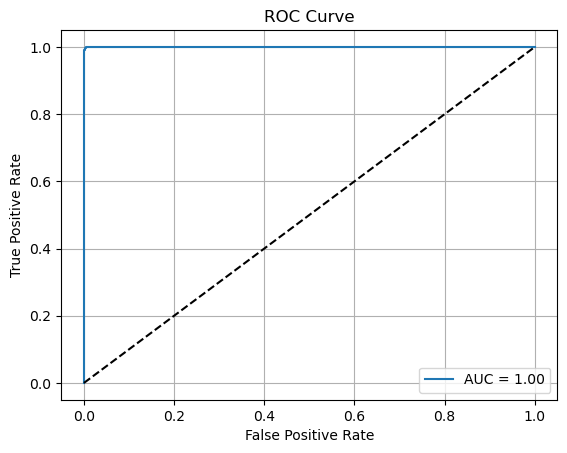

In [6]:
# ROC Curve
y_proba = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
